<a href="https://colab.research.google.com/github/Only-Mike/M2-NLP-Network-Analysis/blob/main/NLP_SC_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dataset as df

This NEEDS to be run first before going further into the assignment

In [5]:
import pandas as pd

In [6]:
# Importing dataset

In [7]:
!git clone https://github.com/Only-Mike/M2-NLP-Network-Analysis.git

Cloning into 'M2-NLP-Network-Analysis'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 87 (delta 43), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (87/87), done.


In [8]:
data1 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2017 csv file.csv')
data2 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2018 csv file.csv')
data3 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2019 csv file.csv')
data4 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2020 csv file.csv')
data5 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2021 csv file.csv')


In [9]:
frames = [data1, data2, data3, data4, data5] #creating frame for all datasets

In [10]:
df = pd.concat(frames) #Concat all datasets to "df"

#Topic modelling

---


In [11]:
#Installing preprocessor to celan our text
!pip install tweet-preprocessor -q

# Installing Gensim and PyLDAvis
!pip install -qq -U gensim
!pip install -qq pyLDAvis

# explainability (why did the model say it's related to this author)
!pip install eli5

     |████████████████████████████████| 24.1 MB 1.4 MB/s 
     |████████████████████████████████| 1.7 MB 7.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 6.5 MB/s 
     |████████████████████████████████| 133 kB 58.2 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=3c2262e3ed4fc1a4b99d52945db570e2be334cb29414c01cbf9d38c2bfe31853
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into ac

In [12]:
import numpy as np
import tqdm #progress bar
import preprocessor as prepro # text prepro

import spacy #spacy for quick language prepro
nlp = spacy.load('en_core_web_sm') #instantiating English module

# sampling, splitting
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


# loading ML libraries
from sklearn.pipeline import make_pipeline #pipeline creation
from sklearn.feature_extraction.text import TfidfVectorizer #transforms text to sparse matrix
from sklearn.linear_model import LogisticRegression #Logit model
from sklearn.metrics import classification_report #that's self explanatory
from sklearn.decomposition import TruncatedSVD #dimensionality reduction
from xgboost import XGBClassifier

import altair as alt #viz

#explainability
import eli5
from eli5.lime import TextExplainer

# topic modeling

from gensim.corpora.dictionary import Dictionary # Import the dictionary builder
from gensim.models import LdaMulticore # we'll use the faster multicore version of LDA

# Import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%matplotlib inline
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [13]:
# prepro settings
prepro.set_options(prepro.OPT.URL, prepro.OPT.NUMBER, prepro.OPT.RESERVED, prepro.OPT.MENTION, prepro.OPT.SMILEY)

In [14]:
df.columns

Index(['Authors', 'Author(s) ID', 'Title', 'Year', 'Source title', 'Cited by',
       'DOI', 'Link', 'Affiliations', 'Authors with affiliations', 'Abstract',
       'Author Keywords', 'Index Keywords', 'Funding Details',
       'Correspondence Address', 'Publisher', 'ISSN', 'ISBN', 'CODEN',
       'Document Type', 'Source', 'EID'],
      dtype='object')

## Cleaning text and embedding the data

In [ ]:
#Choosing the columns we need to work with and storing them in the value "data". This is for saving the "df" dataframe for the prediction model later on.
data = df[['Authors', 'Author(s) ID','Title', 'Abstract','Year', 'Source title']]

In [ ]:
#Take a random sample of 1500 papers. This i for making the model run faster.
data = data.sample(n=1500)

In [ ]:
#Making a new column called "text" from the abstract column
data['text'] = data['Abstract']

In [ ]:
#Cleaning the text
data['text_clean'] = data['text'].map(lambda t: prepro.clean(t))


In [ ]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm.tqdm(total=len(data['text_clean']),position=0, leave=True)

for text in nlp.pipe(data['text_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

  0%|          | 0/1500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|█████████▉| 1499/1500 [00:31<00:00, 187.42it/s]

In [ ]:
# write everything into a single function for simplicity later on
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [ ]:
data['text_clean'] = text_prepro(data['text'])

100%|██████████| 1500/1500 [00:18<00:00, 83.07it/s] 


In [ ]:
# preprocess texts
tokens = []

for summary in nlp.pipe(data['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [ ]:
data['tokens'] = tokens

In [ ]:
# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data['tokens'])

# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 600 words
dictionary.filter_extremes(no_below=4, no_above=0.4, keep_n=600)

# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data['tokens']]

##Visualization

In [ ]:
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=13, workers = 4, passes=10)

In [ ]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
pyLDAvis.display(lda_display)

##Model Metrics

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

In [ ]:
corpus = data['tokens']

In [ ]:
corpus

320     [purpose, paper, aim, bi, objective, mixed, in...
208     [present, research, inventory, management, dec...
1062    [historically, interaction, gas, electricity, ...
1045    [purpose, purpose, paper, distinction, relatio...
241     [traceability, key, food, quality, safety, far...
                              ...                        
1781    [rapid, development, information, technology, ...
1429    [facility, location, model, literature, facili...
810     [purpose, worldwide, resource, pressure, manuf...
1505    [digital, transformation, longstanding, busine...
350     [food, grain, supply, chain, problem, public, ...
Name: tokens, Length: 1500, dtype: object

In [ ]:
dirichlet_dict = corpora.Dictionary(corpus)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in corpus]

# Considering 1-15 topics, as the last is cut off
num_topics = list(range(16)[1:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=bow_corpus,
                             id2word=dirichlet_dict,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [ ]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [ ]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [ ]:
coherences = [CoherenceModel(model=LDA_models[i], texts=corpus, dictionary=dirichlet_dict, coherence='c_v').get_coherence() for i in num_topics[:-1]]

In [ ]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

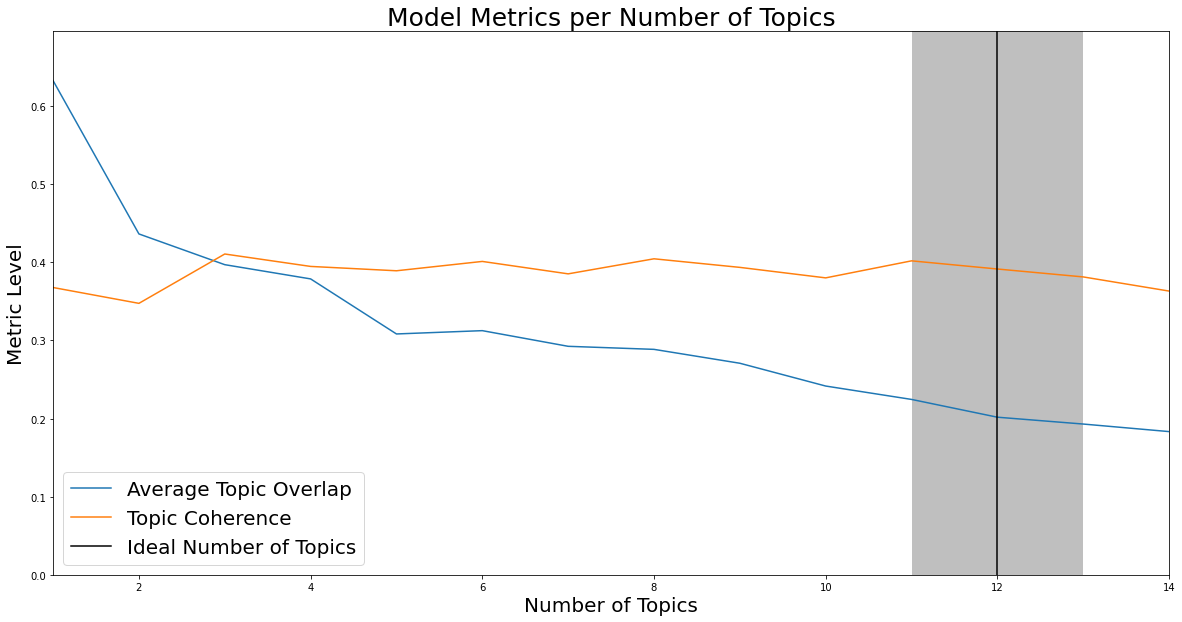

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()  

#Topics over time

---



##Topics 2017

In [15]:
#Choosing the columns we need to work with and storing them in the value "data". This is for saving the "df" dataframe for the prediction model later on.
data1 = data1[['Authors', 'Author(s) ID','Title', 'Abstract','Year', 'Source title']]

In [16]:
#Take a random sample of 500 papers. This i for making the model run faster.
data1 = data1.sample(n=500)

In [17]:
#Making a new column called "text" from the abstract column
data1['text'] = data1['Abstract']

In [18]:
#Cleaning the text
data1['text_clean'] = data1['text'].map(lambda t: prepro.clean(t))


In [19]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm.tqdm(total=len(data1['text_clean']),position=0, leave=True)

for text in nlp.pipe(data1['text_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
 98%|█████████▊| 492/500 [00:08<00:00, 126.06it/s]

In [20]:
# write everything into a single function for simplicity later on
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [21]:
data1['text_clean'] = text_prepro(data1['text'])  ##<---- HVAD GØR DEN HER?<-------##

100%|██████████| 500/500 [00:12<00:00, 39.71it/s] 


In [22]:
# preprocess texts (we need tokens)  <---- Hvad gør den her? <------
tokens = []

for summary in nlp.pipe(data1['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [23]:
data1['tokens'] = tokens

In [24]:

# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data1['tokens'])

# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max XXXXXXX words
dictionary.filter_extremes(no_below=4, no_above=0.4, keep_n=600)

# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data1['tokens']]

###Visualization

In [25]:
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=13, workers = 4, passes=10)

In [26]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [27]:
pyLDAvis.display(lda_display)

## Topics 2018

In [28]:
#Choosing the columns we need to work with and storing them in the value "data". This is for saving the "df" dataframe for the prediction model later on.
data2 = data2[['Authors', 'Author(s) ID','Title', 'Abstract','Year', 'Source title']]

In [29]:
#Take a random sample of 500 papers. This i for making the model run faster.
data2 = data2.sample(n=500)

In [30]:
#Making a new column called "text" from the abstract column
data2['text'] = data2['Abstract']

In [31]:
#Cleaning the text
data2['text_clean'] = data2['text'].map(lambda t: prepro.clean(t))


In [32]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm.tqdm(total=len(data2['text_clean']),position=0, leave=True)

for text in nlp.pipe(data2['text_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

 96%|█████████▌| 480/500 [00:05<00:00, 184.96it/s]

In [33]:
# write everything into a single function for simplicity later on
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [34]:
data2['text_clean'] = text_prepro(data2['text'])

100%|██████████| 500/500 [00:05<00:00, 89.51it/s] 


In [35]:
# preprocess texts
tokens = []

for summary in nlp.pipe(data2['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [36]:
data2['tokens'] = tokens

In [37]:
# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data2['tokens'])

# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 600 words
dictionary.filter_extremes(no_below=4, no_above=0.4, keep_n=600)

# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data2['tokens']]

###Visualization

In [38]:
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=13, workers = 4, passes=10)

100%|██████████| 500/500 [00:22<00:00, 184.96it/s]

In [39]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

In [40]:
pyLDAvis.display(lda_display)

##Topics 2019

In [41]:
#Choosing the columns we need to work with and storing them in the value "data". This is for saving the "df" dataframe for the prediction model later on.
data3 = data3[['Authors', 'Author(s) ID','Title', 'Abstract','Year', 'Source title']]

In [42]:
#Take a random sample of 500 papers. This i for making the model run faster.
data3 = data3.sample(n=500)

In [43]:
#Making a new column called "text" from the abstract column
data3['text'] = data3['Abstract']

In [44]:
#Cleaning the text
data3['text_clean'] = data3['text'].map(lambda t: prepro.clean(t))


In [45]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm.tqdm(total=len(data3['text_clean']),position=0, leave=True)

for text in nlp.pipe(data3['text_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

 98%|█████████▊| 492/500 [00:05<00:00, 194.57it/s]

In [46]:
# write everything into a single function for simplicity later on
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [47]:
data3['text_clean'] = text_prepro(data3['text'])

100%|██████████| 500/500 [00:05<00:00, 88.27it/s] 


In [48]:
# preprocess texts
tokens = []

for summary in nlp.pipe(data3['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [49]:
data3['tokens'] = tokens

In [50]:
# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data3['tokens'])

# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 600 words
dictionary.filter_extremes(no_below=4, no_above=0.4, keep_n=600)

# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data3['tokens']]

###Visualization

In [51]:
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=13, workers = 4, passes=10)

100%|██████████| 500/500 [00:25<00:00, 194.57it/s]

In [52]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

In [53]:
pyLDAvis.display(lda_display)

##Topics 2020

In [54]:
#Choosing the columns we need to work with and storing them in the value "data". This is for saving the "df" dataframe for the prediction model later on.
data4 = data4[['Authors', 'Author(s) ID','Title', 'Abstract','Year', 'Source title']]

In [55]:
#Take a random sample of 500 papers. This i for making the model run faster.
data4 = data4.sample(n=500)

In [56]:
#Making a new column called "text" from the abstract column
data4['text'] = data4['Abstract']

In [57]:
#Cleaning the text
data4['text_clean'] = data4['text'].map(lambda t: prepro.clean(t))


In [58]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm.tqdm(total=len(data4['text_clean']),position=0, leave=True)

for text in nlp.pipe(data4['text_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

100%|██████████| 500/500 [00:06<00:00, 202.66it/s]

In [59]:
# write everything into a single function for simplicity later on
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [60]:
data4['text_clean'] = text_prepro(data4['text'])

100%|██████████| 500/500 [00:05<00:00, 85.55it/s] 


In [61]:
# preprocess texts
tokens = []

for summary in nlp.pipe(data4['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [62]:
data4['tokens'] = tokens

In [63]:
# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data4['tokens'])

# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 600 words
dictionary.filter_extremes(no_below=4, no_above=0.4, keep_n=600)

# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data4['tokens']]

###Visualization

In [64]:
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=13, workers = 4, passes=10)

100%|██████████| 500/500 [00:18<00:00, 202.66it/s]

In [65]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

In [66]:
pyLDAvis.display(lda_display)

##Topics 2021

In [67]:
#Choosing the columns we need to work with and storing them in the value "data". This is for saving the "df" dataframe for the prediction model later on.
data5 = data5[['Authors', 'Author(s) ID','Title', 'Abstract','Year', 'Source title']]

In [68]:
#Take a random sample of 500 papers. This i for making the model run faster.
data5 = data5.sample(n=500)

In [69]:
#Making a new column called "text" from the abstract column
data5['text'] = data5['Abstract']

In [70]:
#Cleaning the text
data5['text_clean'] = data5['text'].map(lambda t: prepro.clean(t))


In [71]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm.tqdm(total=len(data5['text_clean']),position=0, leave=True)

for text in nlp.pipe(data5['text_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

 98%|█████████▊| 488/500 [00:06<00:00, 195.21it/s]

In [72]:
# write everything into a single function for simplicity later on
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [73]:
data5['text_clean'] = text_prepro(data5['text'])

100%|██████████| 500/500 [00:08<00:00, 58.97it/s] 


In [74]:
# preprocess texts
tokens = []

for summary in nlp.pipe(data5['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [75]:
data5['tokens'] = tokens

In [76]:
# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data5['tokens'])

# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 600 words
dictionary.filter_extremes(no_below=4, no_above=0.4, keep_n=600)

# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data5['tokens']]

###Visualization

In [77]:
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=13, workers = 4, passes=10)

100%|██████████| 500/500 [00:21<00:00, 195.21it/s]

In [78]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

In [79]:
pyLDAvis.display(lda_display)

#Label Prediction

---




## Data Cleaning

# Network analysis

---

In this section you'll see our network analysis.  This section contains the:

*   bipartite network of author - paper network and a adjency matrix hereoff.
*   Centrality and community network regarding universities - paper to try and illustrate which universities has the highest output of papers.
 




##Bipartite network ▶ Author - Paper

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt


In [ ]:
!git clone https://github.com/Only-Mike/M2-NLP-Network-Analysis.git

fatal: destination path 'M2-NLP-Network-Analysis' already exists and is not an empty directory.


In [ ]:
# Importing datasets

In [ ]:
data1 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2017 csv file.csv')
data2 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2018 csv file.csv')
data3 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2019 csv file.csv')
data4 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2020 csv file.csv')
data5 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2021 csv file.csv')


In [ ]:
frames = [data1, data2, data3, data4, data5] #creating frame for all datasets

In [ ]:
df = pd.concat(frames) #Concat all datasets to "df"

In [ ]:
#Reduce the sample to 250 papers
df = df.sample(n = 250)

In [ ]:
df

Authors  \
1288  Mirkouei A., Haapala K.R., Sessions J., Murthy...   
1179            Benalcazar P., Kamiński J., Saługa P.W.   
1673               Dahan Y., Lerner H., Milman-Sivan F.   
167                                 He M., Pu J., An Y.   
722   Wang R., Mei Y., Xu L., Zhu X., Wang Y., Guo J...   
...                                                 ...   
8     Fonseca J.P.S., Silva C.E.A., Sousa A.R., Tava...   
288             Ali S.S., Paksoy T., Torğul B., Kaur R.   
1015                    Ma J., Zhang D., Feng D., Tu Y.   
316      Adhitya Y., Prakosa S.W., Köppen M., Leu J.-S.   
1061                         Hamza A.H., Al-Alak S.M.K.   

                                           Author(s) ID  \
1288    56582556200;13005255100;7006468588;57206152242;   
1179                57194009600;55511748805;6506800622;   
1673               25029928300;35321246000;46461648200;   
167                15119034500;57226744464;57226755890;   
722   56079049600;57200331212;57113876100;2476558080...   
...                                                 ...   
8      36132799100;57202502030;36487355400;56892636900;   
288    36099850200;24759277300;57204665627;57213732797;   
1015     57194083698;7405360311;57765936600;7201525583;   
316     57201353015;57193220552;36942759200;8976241800;   
1061                           57214125418;52263193800;   

                                                  Title  Year  \
1288  A review and future directions in techno-econo...  2017   
1179  The storage location problem in a coal supply ...  2017   
1673  Shared Responsibility and Labor Rights in Glob...  2021   
167   Construction of cold chain logistics network o...  2021   
722   Differential proteomic analysis reveals sequen...  2018   
...                                                 ...   ...   
8     Strategies for search and rescue multirobot sy...  2017   
288   Reverse logistics optimization of an industria...  2020   
1015  Dual-Channel Supply Chain Network Equilibrium ...  2018   
316   Feature extraction for cocoa bean digital imag...  2020   
1061  Evaluation key generator of Multiple Asymmetri...  2021   

                                           Source title  Cited by  \
1288           Renewable and Sustainable Energy Reviews      88.0   
1179  Gospodarka Surowcami Mineralnymi / Mineral Res...       8.0   
1673                         Journal of Business Ethics       1.0   
167   Jiangsu Daxue Xuebao (Ziran Kexue Ban)/Journal...       NaN   
722                                              Planta       9.0   
...                                                 ...       ...   
8     Proceedings - 2017 LARS 14th Latin American Ro...       1.0   
288                                   Wireless Networks      24.0   
1015  17th Wuhan International Conference on E-Busin...       NaN   
316                                            Agronomy      10.0   
1061              Journal of Physics: Conference Series       2.0   

                                       DOI  \
1288            10.1016/j.rser.2016.08.053   
1179               10.1515/gospo-2017-0009   
1673            10.1007/s10551-021-04988-w   
167   10.3969/j.issn.1671-7775.2021.06.009   
722              10.1007/s00425-018-2846-5   
...                                    ...   
8          10.1109/SBR-LARS-R.2017.8215338   
288             10.1007/s11276-019-02246-6   
1015                                   NaN   
316               10.3390/agronomy10111642   
1061       10.1088/1742-6596/1804/1/012096   

                                                   Link  \
1288  https://www.scopus.com/inward/record.uri?eid=2...   
1179  https://www.scopus.com/inward/record.uri?eid=2...   
1673  https://www.scopus.com/inward/record.uri?eid=2...   
167   https://www.scopus.com/inward/record.uri?eid=2...   
722   https://www.scopus.com/inward/record.uri?eid=2...   
...                                                 ...   
8     https://www.scopus.com/inward/record.uri?eid=2..

In [ ]:
df = df.drop(index=df[df['Authors'] == '[No author name available]'].index, axis=0)

In [ ]:
df.shape

(243, 22)

In [ ]:
df.columns

Index(['Authors', 'Author(s) ID', 'Title', 'Year', 'Source title', 'Cited by',
       'DOI', 'Link', 'Affiliations', 'Authors with affiliations', 'Abstract',
       'Author Keywords', 'Index Keywords', 'Funding Details',
       'Correspondence Address', 'Publisher', 'ISSN', 'ISBN', 'CODEN',
       'Document Type', 'Source', 'EID'],
      dtype='object')

In [ ]:
#Make an edgelist
edgelist = []
for i in df.iterrows():
  targets = i[1]['Authors'].split(',')
  edgelist_i = [(i[1]['EID'], j) for j in targets]
  edgelist.extend(edgelist_i)

In [ ]:
edgelist[3]  #<---- Show small sample of the data

('2-s2.0-84986597336', ' Murthy G.S.')

In [ ]:
len(edgelist)

774

In [ ]:
import networkx as nx

In [ ]:
from networkx.algorithms import bipartite

In [ ]:
c0 = set([c[1] for c in edgelist])
c1 = set([c[0] for c in edgelist])

In [ ]:
B = nx.Graph()

In [ ]:
# add nodes and edges in their modes
B.add_nodes_from(c0, bipartite=0)
B.add_nodes_from(c1, bipartite=1)
B.add_edges_from(edgelist)

In [ ]:
top_nodes = [n for n in B.nodes if B.nodes[n]['bipartite'] == 0]


In [ ]:
G = bipartite.collaboration_weighted_projected_graph(B, top_nodes)

In [ ]:
#this code removes nodes with degress (edges) of 1 or less
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
G.remove_nodes_from(to_be_removed)

In [ ]:
edges_df = nx.to_pandas_edgelist(B)
edges_df

source              target
0           Hermawan P.  2-s2.0-85092207887
1       Galanopoulos C.  2-s2.0-85069740839
2          Hemalatha S.  2-s2.0-85057734184
3         Yavuzaslan K.  2-s2.0-85126217681
4     Sáez-Navarrete C.  2-s2.0-85107567763
..                  ...                 ...
769           Furian N.  2-s2.0-85050015984
770            Pooja S.  2-s2.0-85099683217
771        Silva C.E.A.  2-s2.0-85048521032
772           Kim K.-Y.  2-s2.0-85023644071
773          Mahjoob M.  2-s2.0-85137968471

[774 rows x 2 columns]

In [ ]:
# For visualization
!pip install -U bokeh
!pip install -q holoviews

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached bokeh-2.4.3-py3-none-any.whl (18.5 MB)
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.3.3
    Uninstalling bokeh-2.3.3:
      Successfully uninstalled bokeh-2.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.12.1 requires bokeh<2.4.0,>=2.3.0, but you have bokeh 2.4.3 which is incompatible.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
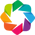

In [ ]:
# Import the libraries and link to the bokeh backend
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from bokeh.plotting import show

# Setting the default figure size a bit larger
defaults = dict(width=750, height=750, padding=0.1,
                xaxis=None, yaxis=None)
hv.opts.defaults(
    opts.EdgePaths(**defaults), opts.Graph(**defaults), opts.Nodes(**defaults))

In [ ]:
G_layout = nx.layout.kamada_kawai_layout(G)

In [ ]:
g_plot = hv.Graph.from_networkx(G, G_layout).opts(tools=['hover'],
                                                                        directed=False,
                                                                        edge_alpha=0.4,
                                                                        node_size= 5,
                                                                        #node_color='seniority', cmap='Set1',
                                                                        legend_position='right')
show(hv.render(g_plot))

## Centrality and communty network ▶ University - Paper

In [ ]:
#Import the data again to run the full dataset

In [ ]:
data1 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2017 csv file.csv')
data2 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2018 csv file.csv')
data3 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2019 csv file.csv')
data4 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2020 csv file.csv')
data5 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2021 csv file.csv')


In [ ]:
frames = [data1, data2, data3, data4, data5] #creating frame for all datasets

In [ ]:
df = pd.concat(frames) #Concat all datasets to "df"

In [ ]:
df = df.drop(index=df[df['Authors'] == '[No author name available]'].index, axis=0)

In [ ]:
df['Affiliations'].value_counts(ascending=False).nlargest(20)

School of Industrial Engineering, Iran University of Science and Technology, Tehran, Iran                                                                                                                                                                                                               21
School of Industrial Engineering, College of Engineering, University of Tehran, Tehran, Iran                                                                                                                                                                                                            17
Department of Industrial Engineering, Faculty of Engineering, Kharazmi University, Tehran, Iran                                                                                                                                                                                                         14
Department of Industrial Engineering, Babol Noshirvani University of Technology, Babol, Iran           

### Edgelist construction

In [ ]:
# select Authors and EID
data_select = [['Authors', 'EID', 'Affiliations']]

In [ ]:
# create edge Dataframe by merging it with itself.
edges = pd.merge(data_select, data_select, on='Affiliations')
edges.head()

Authors               EID_x  \
0                   Crush J., Frayne B., McCordic C.  2-s2.0-85046049829   
1  Tsang Y.P., Choy K.L., Wu C.H., Ho G.T.S., Lam...  2-s2.0-85039850983   
2                                       Secomandi N.  2-s2.0-85039788219   
3    Korhonen K., Kotavaara O., Muilu T., Rusanen J.  2-s2.0-85041059781   
4                      Ismail A.H., Mahardika R.Z.Z.  2-s2.0-85039755236   

                                      Affiliations_x               EID_y  \
0  University of Cape Town, South Africa; School ...  2-s2.0-85046049829   
1  Department of Industrial and Systems Engineeri...  2-s2.0-85039850983   
2  Tepper School of Business, Carnegie Mellon Uni...  2-s2.0-85039788219   
3  Natural Resources Institute Finland, Universit...  2-s2.0-85041059781   
4  Department of Industrial Engineering, Pancasil...  2-s2.0-85039755236   

                                      Affiliations_y  
0  University of Cape Town, South Africa; School ...  
1  Department of Industrial and Systems Engineeri...  
2  Tepper School of Business, Carnegie Mellon Uni...  
3  Natural Resources Institute Finland, Universit...  
4  Department of Industrial Engineering, Pancasil...

In [ ]:
# Filter out the self-edges
edges = edges[edges['EID_x'] != edges['EID_y']]

We are now in a situation whre people that sit in multiple boards together will have one row per board. This can be aggregated in the following way by grouping.



In [ ]:
# grouping to aggregate multiple co-occurences and to generate a weight: 
edges = edges.groupby(['EID_x', 'EID_y']).size().reset_index()

In [ ]:
edges.reset_index(drop=True, inplace=True)

In [ ]:
# column "0" is now our weight
edges.head()

Affiliations_x  \
0  ABV-Indian Institute of Information Technology...   
1  ABV-Indian Institute of Information Technology...   
2  ABV-Indian Institute of Information Technology...   
3  ABV-Indian Institute of Information Technology...   
4  ABV-Indian Institute of Information Technology...   

                                      Affiliations_y  0  
0  Department of Management Studies (DoMS), India...  2  
1  Management Division, ABV- Indian Institute of ...  1  
2  Management Division, ABV-Indian Institute of I...  1  
3  ABV-Indian Institute of Information Technology...  1  
4  ABV-Indian Institute of Information Technology...  1

In [ ]:
# Eename the "0" column to weight
edges.rename({0:'weight'}, axis = 1, inplace=True)

In [ ]:
edges.head()

Affiliations_x  \
0  ABV-Indian Institute of Information Technology...   
1  ABV-Indian Institute of Information Technology...   
2  ABV-Indian Institute of Information Technology...   
3  ABV-Indian Institute of Information Technology...   
4  ABV-Indian Institute of Information Technology...   

                                      Affiliations_y  weight  
0  Department of Management Studies (DoMS), India...       2  
1  Management Division, ABV- Indian Institute of ...       1  
2  Management Division, ABV-Indian Institute of I...       1  
3  ABV-Indian Institute of Information Technology...       1  
4  ABV-Indian Institute of Information Technology...       1

In [ ]:
len(edges)

536

In [ ]:
# Create network object from pandas edgelist
G = nx.from_pandas_edgelist(edges, source='EID_x', target='EID_y', edge_attr='weight', create_using=nx.Graph())

Using a pandas edgelist as source is a source for the graph object allows us to instantiate it with the weight attribute included

In [ ]:
# We can create a node-attribute dictionary directly from the dataframe (using pandas to_dict)
node_attributes = data_select[['EID','Affiliations']].set_index('EID').drop_duplicates().to_dict('index')

ValueError: ignored

In [ ]:
# We now can include the degree as node-attribute
nx.set_node_attributes(G, {G.degree(): 'degree'})

In [ ]:
# and use the node_attribute object to include all that in the graph object
nx.set_node_attributes(G, node_attributes)

In [ ]:
len(G.nodes())

548

In [ ]:
len(G.edges())

1338

Subsetting og Graph objects in NetworkX is a bit of a challenge sometimes - Well, you need to remember that NetworkX wants us to pass a list of Node-IDs for subsetting. The easiest here (probably also most elegant) is to use a list comprehension with a condition statemen `if d > 1`

In [ ]:
# Subset the graph keeping only nodes with degree > 1
G = nx.subgraph(G, [n for n,d in G.degree() if d > 1])

In [ ]:
# Here we can calculate different centrality indicators as well as partition (community detection)
centrality_dgr = nx.degree_centrality(G)
centrality_eig = nx.eigenvector_centrality_numpy(G, weight = 'weight')

In [ ]:
from community import community_louvain

In [ ]:
partition = community_louvain.best_partition(G)

In [ ]:
# All these indicators can now be set as attribute of the Graph
nx.set_node_attributes(G, centrality_dgr, 'dgr')
nx.set_node_attributes(G, centrality_eig, 'eig')
nx.set_node_attributes(G, partition, 'partition')

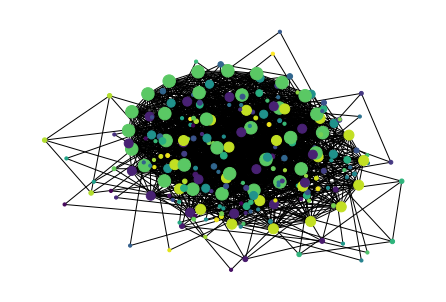

In [ ]:
#Quick plot of the centrality degree
nx.draw_kamada_kawai(G, node_color=list(partition.values()), node_size=[v * 5 for v in dict(G.degree()).values()])

In [ ]:
# Turn the Graph object (NetworkX) into a Dataframe
nodes_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [ ]:
nodes_df.head()

Affiliations  \
2-s2.0-85049334532  Department of Industrial Engineering, Universi...   
2-s2.0-85029157546  Department of Industrial Engineering, Babol No...   
2-s2.0-85105825290  Department of Mathematics and Computer Science...   
2-s2.0-85006786171  Faculty of Engineering, Urmia University, Urmi...   
2-s2.0-85067035084  Industrial and Systems Engineering Department,...   

                         dgr           eig  partition  
2-s2.0-85049334532  0.017167  2.444880e-17         28  
2-s2.0-85029157546  0.038627 -1.950859e-17         27  
2-s2.0-85105825290  0.008584  5.071435e-18         15  
2-s2.0-85006786171  0.021459 -7.661790e-17          3  
2-s2.0-85067035084  0.008584 -7.489038e-19         43

Let's see who are the most central people in DK.
I guess, you'll not be surprised by the result

In [ ]:
# Sort dataframe by eigenvector.
nodes_df.sort_values('eig', ascending=False)[:10]

Affiliations       dgr       eig  partition
2-s2.0-85019946231          NaN  0.133047  0.176777         32
2-s2.0-85044920317          NaN  0.133047  0.176777         32
2-s2.0-85018779318          NaN  0.133047  0.176777         32
2-s2.0-85113705285          NaN  0.133047  0.176777         32
2-s2.0-85093922453          NaN  0.133047  0.176777         32
2-s2.0-85088906981          NaN  0.133047  0.176777         32
2-s2.0-85051474179          NaN  0.133047  0.176777         32
2-s2.0-85107310396          NaN  0.133047  0.176777         32
2-s2.0-85093986499          NaN  0.133047  0.176777         32
2-s2.0-85129802009          NaN  0.133047  0.176777         32

Let's see if we can find out about the largest communities and the most central people within these:

In [ ]:
# How many communities are there.
nodes_df.partition.nunique()

44

In [ ]:
#define top10_com as partition value counts
top10_com = nodes_df.partition.value_counts()[:10].index

In [ ]:
top10_com_nodes = nodes_df[nodes_df.partition.isin(top10_com)].index

# Make a subgraph
g_sub = nx.subgraph(G, top10_com_nodes)


In [ ]:
# Now we will limit the resulting dataframe to the top10 communities
nodes_df_top10 = nodes_df[nodes_df.partition.isin(top10_com)]

In [ ]:
nodes_df_top10

Affiliations  \
2-s2.0-85049334532  Department of Industrial Engineering, Universi...   
2-s2.0-85029157546  Department of Industrial Engineering, Babol No...   
2-s2.0-85006786171  Faculty of Engineering, Urmia University, Urmi...   
2-s2.0-85026477444  Department of Industrial Engineering, South Te...   
2-s2.0-85035749631  School of Management, Shanghai University, Sha...   
...                                                               ...   
2-s2.0-85060956096                                                NaN   
2-s2.0-85101568493                                                NaN   
2-s2.0-85108621093                                                NaN   
2-s2.0-85069619047                                                NaN   
2-s2.0-85034250783                                                NaN   

                         dgr           eig  partition  
2-s2.0-85049334532  0.017167  2.444880e-17         28  
2-s2.0-85029157546  0.038627 -1.950859e-17         27  
2-s2.0-85006786171  0.021459 -7.661790e-17          3  
2-s2.0-85026477444  0.021459  3.910108e-17          8  
2-s2.0-85035749631  0.021459 -6.951371e-17         11  
...                      ...           ...        ...  
2-s2.0-85060956096  0.055794 -1.812427e-17         22  
2-s2.0-85101568493  0.068670  3.295975e-17          4  
2-s2.0-85108621093  0.068670  2.428613e-17          4  
2-s2.0-85069619047  0.085837 -8.673617e-17         39  
2-s2.0-85034250783  0.068670  6.938894e-18          4  

[124 rows x 4 columns]

In [ ]:
# with the highest eigenvector centrality
top_affiliations = nodes_df_top10.groupby('partition')['eig'].nlargest(5).reset_index()

In [ ]:
top_affiliations

partition             level_1           eig
0           3  2-s2.0-85114770538 -1.876761e-17
1           3  2-s2.0-85083287791 -3.093305e-17
2           3  2-s2.0-85064985567 -3.646534e-17
3           3  2-s2.0-85047417458 -4.322794e-17
4           3  2-s2.0-85051832727 -6.298653e-17
5           4  2-s2.0-85109409281  5.714095e-17
6           4  2-s2.0-85062871610  4.583231e-17
7           4  2-s2.0-85124403903  4.438426e-17
8           4  2-s2.0-85053541406  4.226916e-17
9           4  2-s2.0-85107148163  4.164262e-17
10          8  2-s2.0-85052948616  4.433709e-17
11          8  2-s2.0-85026477444  3.910108e-17
12          8  2-s2.0-85092056851  2.292216e-17
13          8  2-s2.0-85055121581  2.131463e-17
14          8  2-s2.0-85096462451  1.702685e-17
15         11  2-s2.0-85090406867 -5.121221e-17
16         11  2-s2.0-85065801174 -5.395231e-17
17         11  2-s2.0-85041668544 -5.936478e-17
18         11  2-s2.0-85077889358 -6.710392e-17
19         11  2-s2.0-85035749631 -6.951371e-17
20         14  2-s2.0-85065232148  5.984107e-17
21         14  2-s2.0-85040007536  3.881797e-17
22         14  2-s2.0-85042361738  3.238662e-17
23         14  2-s2.0-85029470458  3.200779e-17
24         14  2-s2.0-85049883342  2.154016e-17
25         22  2-s2.0-85054137698  1.806075e-17
26         22  2-s2.0-85047537773  1.743317e-17
27         22  2-s2.0-85047799347  3.364778e-18
28         22  2-s2.0-85073473444  2.919952e-18
29         22  2-s2.0-85104364662  1.064666e-18
30         27  2-s2.0-85091201330 -6.852264e-18
31         27  2-s2.0-85068389846 -1.493837e-17
32         27  2-s2.0-85029157546 -1.950859e-17
33         27  2-s2.0-85039436630 -2.076004e-17
34         27  2-s2.0-85104890978 -2.471550e-17
35         28  2-s2.0-85049735805  3.168124e-17
36         28  2-s2.0-85049334532  2.444880e-17
37         28  2-s2.0-85032988721  1.532376e-17
38         28  2-s2.0-85042612061  1.089000e-17
39         28  2-s2.0-85046759087 -8.552151e-18
40         32  2-s2.0-85019946231  1.767767e-01
41         32  2-s2.0-85044920317  1.767767e-01
42         32  2-s2.0-85018779318  1.767767e-01
43         32  2-s2.0-85051474179  1.767767e-01
44         32  2-s2.0-85067647571  1.767767e-01
45         39  2-s2.0-85073948769 -4.646581e-17
46         39  2-s2.0-85044681174 -5.244747e-17
47         39  2-s2.0-85030859511 -5.308600e-17
48         39  2-s2.0-85098698469 -5.338753e-17
49         39  2-s2.0-85108891107 -5.615384e-17

In [ ]:
# After that we need to bring back ID's (rename) and Names (merge)
top_affiliations.rename({'level_1':'EID'}, axis=1, inplace=True)
top_affiliations = pd.merge(top_people, data_select[['Affiliations','EID']].drop_duplicates(), on='EID', how='inner')

In [ ]:
top_affiliations

partition                 EID           eig  \
0           3  2-s2.0-85114770538 -1.876761e-17   
1           3  2-s2.0-85083287791 -3.093305e-17   
2           3  2-s2.0-85064985567 -3.646534e-17   
3           3  2-s2.0-85047417458 -4.322794e-17   
4           3  2-s2.0-85051832727 -6.298653e-17   
5           4  2-s2.0-85109409281  5.714095e-17   
6           4  2-s2.0-85062871610  4.583231e-17   
7           4  2-s2.0-85124403903  4.438426e-17   
8           4  2-s2.0-85053541406  4.226916e-17   
9           4  2-s2.0-85107148163  4.164262e-17   
10          8  2-s2.0-85052948616  4.433709e-17   
11          8  2-s2.0-85026477444  3.910108e-17   
12          8  2-s2.0-85092056851  2.292216e-17   
13          8  2-s2.0-85055121581  2.131463e-17   
14          8  2-s2.0-85096462451  1.702685e-17   
15         11  2-s2.0-85090406867 -5.121221e-17   
16         11  2-s2.0-85065801174 -5.395231e-17   
17         11  2-s2.0-85041668544 -5.936478e-17   
18         11  2-s2.0-85077889358 -6.710392e-17   
19         11  2-s2.0-85035749631 -6.951371e-17   
20         14  2-s2.0-85065232148  5.984107e-17   
21         14  2-s2.0-85040007536  3.881797e-17   
22         14  2-s2.0-85042361738  3.238662e-17   
23         14  2-s2.0-85029470458  3.200779e-17   
24         14  2-s2.0-85049883342  2.154016e-17   
25         22  2-s2.0-85054137698  1.806075e-17   
26         22  2-s2.0-85047537773  1.743317e-17   
27         22  2-s2.0-85047799347  3.364778e-18   
28         22  2-s2.0-85073473444  2.919952e-18   
29         22  2-s2.0-85104364662  1.064666e-18   
30         27  2-s2.0-85091201330 -6.852264e-18   
31         27  2-s2.0-85068389846 -1.493837e-17   
32         27  2-s2.0-85029157546 -1.950859e-17   
33         27  2-s2.0-85039436630 -2.076004e-17   
34         27  2-s2.0-85104890978 -2.471550e-17   
35         28  2-s2.0-85049735805  3.168124e-17   
36         28  2-s2.0-85049334532  2.444880e-17   
37         28  2-s2.0-85032988721  1.532376e-17   
38         28  2-s2.0-85042612061  1.089000e-17   
39         28  2-s2.0-85046759087 -8.552151e-18   
40         32  2-s2.0-85019946231  1.767767e-01   
41         32  2-s2.0-85044920317  1.767767e-01   
42         32  2-s2.0-85018779318  1.767767e-01   
43         32  2-s2.0-85051474179  1.767767e-01   
44         32  2-s2.0-85067647571  1.767767e-01   
45         39  2-s2.0-85073948769 -4.646581e-17   
46         39  2-s2.0-85044681174 -5.244747e-17   
47         39  2-s2.0-85030859511 -5.308600e-17   
48         39  2-s2.0-85098698469 -5.338753e-17   
49         39  2-s2.0-85108891107 -5.615384e-17   

                                       Affiliations_x  \
0   Faculty of Engineering, Urmia University, Urmi...   
1   Faculty of Engineering, Urmia University, Urmi...   
2   Faculty of Engineering, Urmia University, Urmi...   
3   Faculty of Engineering, Urmia University, Urmi...   
4   Faculty of Engineering, Urmia University, Urmi...   
5   School of Industrial Engineering, College of E...   
6   School of Industrial Engineering, College of E...   
7   School of Industrial Engineering, College of E...   
8   School of Industrial Engineering, College of E...   
9   School of Industrial Engineering, College of E...   
10  Department of Industrial Engineering, South Te...   
11  Department of Industrial Engineering, South Te...   
12  Department of Industrial Engineering, South Te...   
13  Department of Industrial Engineering, South Te...   
14  Department of Industrial Engineering, South Te...   
15  School of Management, Shanghai University, Sha...   
16  School of Management, Shanghai University, Sha...   
17  School of Management, Shanghai University, Sha...   
18  School of Management, Shanghai University, Sha...   
19  School of Management, Shanghai University, Sha...   
20  Department of Industrial Engineering, Faculty ...   
21  Department of Industrial Engineering, Faculty ...   
22  Department of Industrial Engineering, Faculty ...   
23  Department of Industrial Engin

### Visualisations



In [ ]:
!pip install -qq holoviews
!pip install -qq -U bokeh
!pip install -qq datashader

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.12.1 requires bokeh<2.4.0,>=2.3.0, but you have bokeh 2.4.3 which is incompatible.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
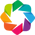

In [ ]:
# Import the libraries and link to the bokeh backend
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from bokeh.plotting import show
kwargs = dict(width=800, height=800, xaxis=None, yaxis=None)
opts.defaults(opts.Nodes(**kwargs), opts.Graph(**kwargs))

In [ ]:
# keeping only top nodes (extreme subsetting)
top_central_nodes = nodes_df[nodes_df.eig > nodes_df.eig.quantile(0.99)].index

In [ ]:
# Create subset graph
g_sub = nx.subgraph(G, top_central_nodes)

In [ ]:
#Calculate the centrality degree
cent_degree = dict(nx.degree(G))

In [ ]:
#Calculate the eigen degree
cent_eigen = dict(nx.eigenvector_centrality(G))

In [ ]:
#Plot centrality degree graph
nx.set_node_attributes(G, cent_degree, 'cent_degree')

g_plot = hv.Graph.from_networkx(G, G_layout).opts(tools=['hover'],
                                                  node_size='cent_degree')

show(hv.render(g_plot))

In [ ]:
#Plot centrality eigenvalue graph
nx.set_node_attributes(G, cent_eigen, 'cent_eigen')

g_plot = hv.Graph.from_networkx(G, G_layout).opts(tools=['hover'],
                                                  node_size='cent_eigen')

show(hv.render(g_plot))

In [ ]:
# Find the optimal partition with the Louvain algorithm.
com = community_louvain.best_partition(G)

In [ ]:
# The number of communities detected
max(com.values())

43

In [ ]:
#Plot community network
nx.set_node_attributes(G, com, 'community')

g_plot = hv.Graph.from_networkx(G, G_layout).opts(tools=['hover'],
                                                  node_size='cent_degree', 
                                                  node_color='community', cmap=plt.cm.Set1,
                                                  legend_position='right',
                                                  edge_alpha=0.25)

show(hv.render(g_plot))